In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn
from scikits.bootstrap import ci
import glob
from IPython.core.display import display
from scipy.sparse import csr_matrix

# credit to http://people.duke.edu/~ccc14/pcfb/analysis.html
def bootstrap(data, num_samples, statistic, alpha=0.05):
    """Returns bootstrap estimate of 100.0*(1-alpha) CI for statistic."""
    n = len(data)
    idx = np.random.randint(0, n, (num_samples, n))
    samples = data[idx]
    stat = np.sort(statistic(samples, 1))
    return (stat[int((alpha/2.0)*num_samples)],
            stat[int((1-alpha/2.0)*num_samples)])


# Artist jump distributions

In [34]:
artist_jump_data = pd.read_table('../foragingAnalysis/MPA/jumpdists',header=None,names=['userid','vals'])
arr = np.array([[int(val) for val in row.split(',')] for row in artist_jump_data['vals']])
arrmean = arr/arr.sum(1,keepdims=True).astype(float)

arr_complete = np.loadtxt('../testData/jumpdists_all',delimiter=',',dtype=int)
arrmean_complete = arr_complete/arr_complete.sum(1,keepdims=True).astype(float)

In [52]:
randhops = np.array([   4342755,    2758453,    2434669,    2270920,    2119710,
          2053161,    1994882,    1959341,    1922705,    1902292,
          1892862,    1877426,    1874080,    1863727,    1855469,
          1848940,    1858326,    1880130,    1885815,    1897211,
          1909684,    1934096,    1953835,    1976156,    2017692,
          2040944,    2055485,    2083535,    2114429,    2150651,
          2194113,    2249135,    2272474,    2325105,    2367550,
          2416719,    2462595,    2521398,    2563528,    2604849,
          2695258,    2756460,    2803823,    2894244,    2966559,
          3045459,    3137227,    3217971,    3304616,    3385290,
          3506161,    3615485,    3728882,    3852841,    3975289,
          4116962,    4259949,    4393680,    4565909,    4735030,
          4915608,    5110211,    5321315,    5547767,    5769740,
          6032796,    6311921,    6592636,    6909131,    7272314,
          7651422,    8037429,    8455876,    8947052,    9463727,
         10038245,   10639356,   11368518,   12177166,   13061866,
         13993453,   15108969,   16321222,   17704845,   19340282,
         21231830,   23451106,   26002318,   29150758,   33027899,
         37755290,   43726509,   51365877,   61696002,   76176436,
         97894469,  133221492,  199900812,  374739922, 4697838987])
randhops = randhops / float(randhops.sum())
randhops_mini = np.load('../testData/100Mrandhops.npy')

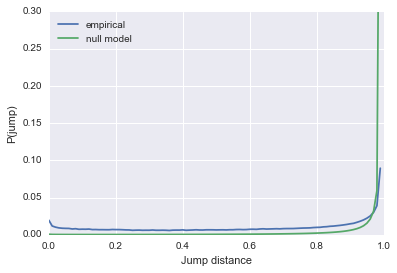

In [47]:
bins = np.arange(0,1.01,0.01)
fig,ax = plt.subplots(1,1)

ax.plot(bins[:-1],np.nanmean(arrmean,0),label='empirical')
ax.plot(bins[:-1],randhops,label='null model')
ax.set_xlabel('Jump distance')
ax.set_ylabel('P(jump)')
ax.set_ylim(0,0.3)
ax.legend(loc='upper left')

In [54]:
ci_lower = []
ci_upper = []
for i in xrange(arrmean.shape[1]):
    #lower,upper = ci(arrmean[:,i],statfunction=np.nanmean,n_samples=1000)
    lower,upper = bootstrap(arrmean[:,i],statistic=np.nanmean,num_samples=1000)
    ci_lower.append(lower)
    ci_upper.append(upper)
    
ci_lower_ = []
ci_upper = []
for i in xrange(arrmean.shape[1]):
    #lower,upper = ci(arrmean[:,i],statfunction=np.nanmean,n_samples=1000)
    lower,upper = bootstrap(arrmean[:,i],statistic=np.nanmean,num_samples=1000)
    ci_lower.append(lower)
    ci_upper.append(upper)

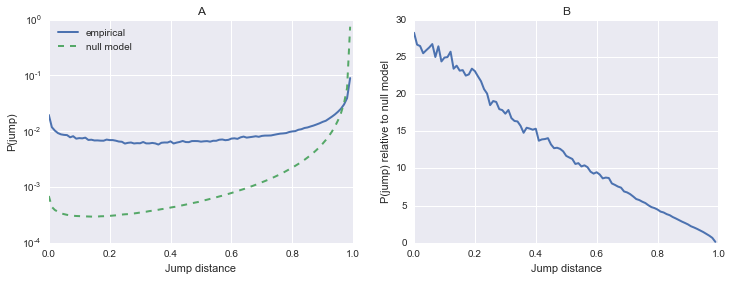

In [70]:
bins = np.arange(0,1.01,0.01)
fig,axes = plt.subplots(1,2,figsize=(12,4))
#ax.plot(bins[:-1],np.nanmean(arrmean,0)/randhops)
ax = axes[0]
ax.plot(bins[:-1],np.nanmean(arrmean,0),label='empirical',lw=2)
ax.plot(bins[:-1],randhops,label='null model',lw=2,ls='--')
#ax.fill_between(bins[:-1],np.array(ci_lower),np.array(ci_upper),alpha=0.5)
ax.set_title('A')
ax.set_xlabel('Jump distance')
ax.set_ylabel('P(jump)')
#ax.set_ylim(0,0.3)
ax.set_yscale('log')
ax.legend(loc='upper left')


ax = axes[1]
ax.plot(bins[:-1],np.nanmean(arrmean_complete,0)/randhops,lw=2)
#ax.plot(bins[:-1],np.nanmean(arrmean_complete,0)/randhops_mini)
#ax.fill_between(bins[:-1],(np.nanmean(arrmean_complete,0)/randhops)-np.array(ci_lower),(np.nanmean(arrmean_complete,0)/randhops)+np.array(ci_upper),alpha=0.5)
ax.set_xlabel('Jump distance')
ax.set_ylabel('P(jump) relative to null model')
ax.set_title('B')

# Patch segmentation parameter exploration

In [112]:
df = pd.read_table('../testData/patch_len_dists_concat',header=None,names=['user','method','hist_type','dist','mpl','d'])
df['d'] = df['d'].apply(lambda d: np.array(d.split(','),dtype=float))

# drop garbage user
#df = df[df['user']!=6041368]

(0, 25)

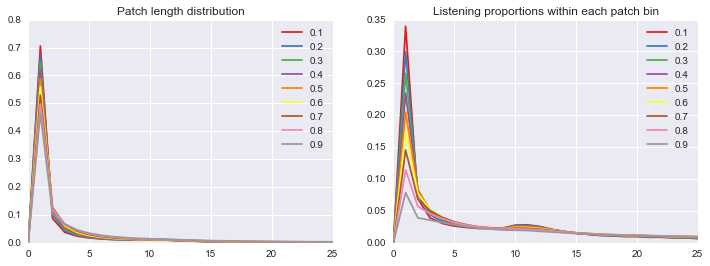

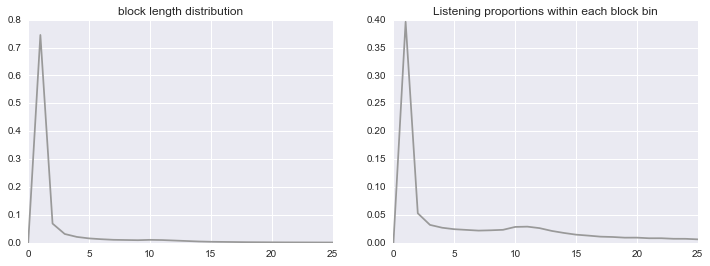

In [246]:
def grouper(df):
    result = np.zeros(1000)
    for d in df['d']:
        d = d.copy()
        
        d =  d/float(d.sum())
        result += d
    return result / float(len(df))

simple_means = df[(df['method']=='simple')&(df['hist_type']=='patches')].groupby('dist').apply(grouper)
fig,axes = plt.subplots(1,2,figsize=(12,4))
colors = seaborn.color_palette('Set1',n_colors=9)
ax = axes[0]
for i,(dist,d) in enumerate(simple_means.iteritems()):
    ax.plot(d,label=dist,c=colors[i])
ax.legend()
ax.set_xlim(0,25)
ax.set_title('Patch length distribution')

ax = axes[1]
simple_means = df[(df['method']=='simple')&(df['hist_type']=='listens')].groupby('dist').apply(lambda df: df['d'].mean())
for i,(dist,d) in enumerate(simple_means.iteritems()):
    ax.plot(d,label=dist,c=colors[i])
ax.legend()
ax.set_xlim(0,25)
ax.set_title('Listening proportions within each patch bin')

simple_means = df[(df['method']=='block')&(df['hist_type']=='patches')&(df['dist']==0.1)]['d'].apply(lambda x: x/x.sum()).mean()
fig,axes = plt.subplots(1,2,figsize=(12,4))
colors = seaborn.color_palette('Set1',n_colors=9)
ax = axes[0]
ax.plot(simple_means,label=dist,c=colors[i])
ax.set_title('block length distribution')

ax.set_xlim(0,25)
ax = axes[1]
simple_means = df[(df['method']=='block')&(df['hist_type']=='listens')&(df['dist']==0.1)]['d'].mean()

ax.plot(simple_means,label=dist,c=colors[i])
ax.set_title('Listening proportions within each block bin')
ax.set_xlim(0,25)

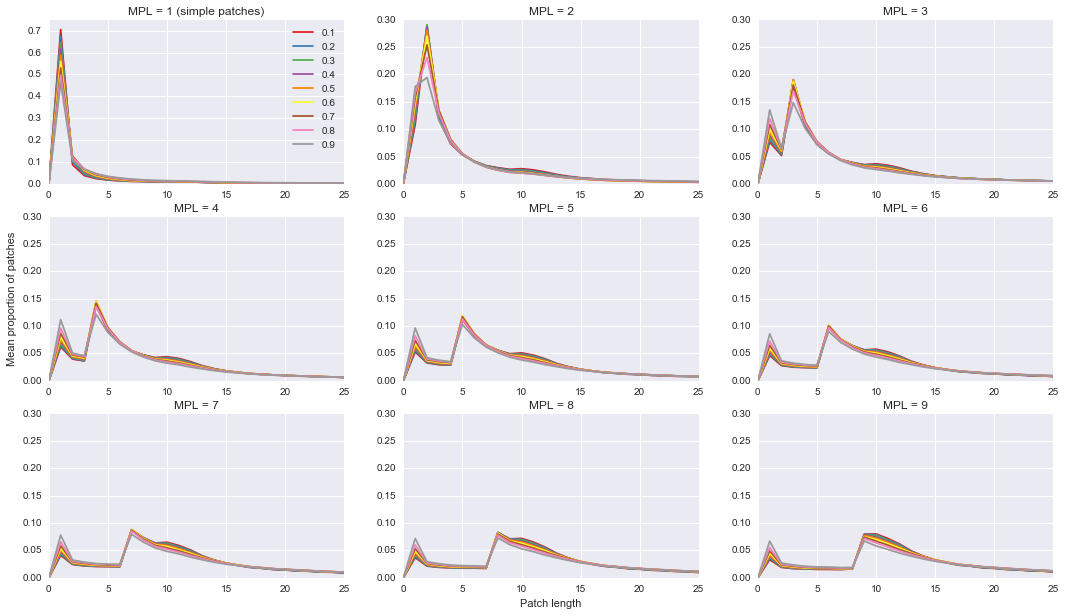

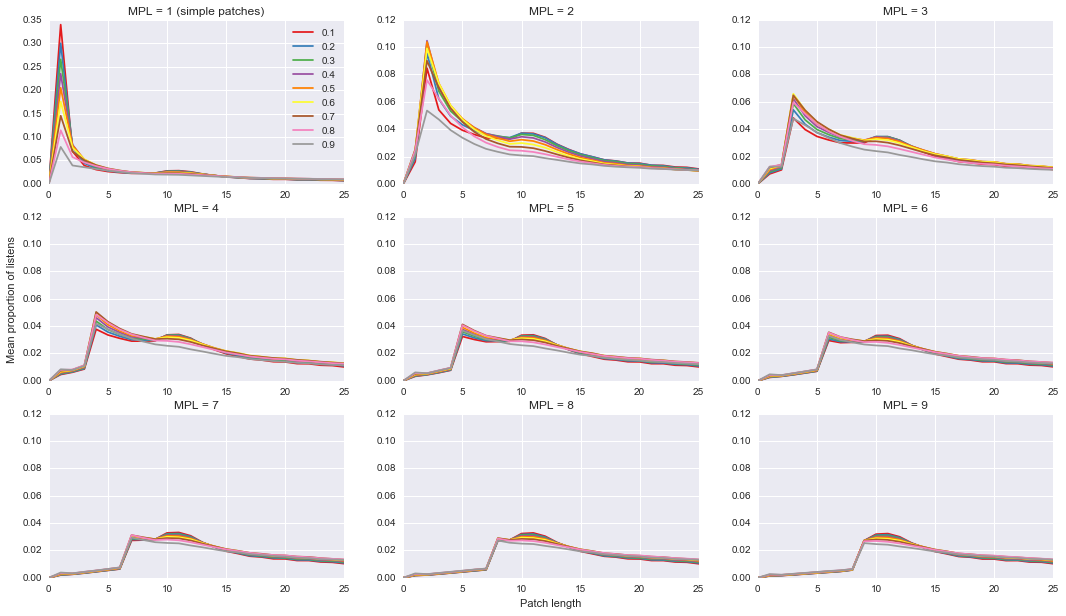

In [256]:
shuffle_means = df[(df['method']=='shuffle')&(df['hist_type']=='patches')].groupby(['dist','mpl']).apply(grouper)
fig,axes = plt.subplots(3,3,figsize=(18,10))
ax_iter = axes.flat
colors = seaborn.color_palette('Set1',n_colors=9)

simple_means = df[(df['method']=='simple')&(df['hist_type']=='patches')].groupby('dist').apply(grouper)
ax = ax_iter.next()
for i,(dist,d) in enumerate(simple_means.iteritems()):
    ax.plot(d,label=dist,c=colors[i])
ax.legend()
ax.set_xlim(0,25)
ax.set_ylim(0,0.75)
ax.set_title('MPL = 1 (simple patches)')
# ax.set_xlabel('Patch length')
# ax.set_ylabel('Mean proportion of patches')

for idx,grp in enumerate(sorted(shuffle_means.index.levels[1][:-1])):
    ax = ax_iter.next()
    for i,(dist,d) in enumerate(shuffle_means.xs(grp,level='mpl').iteritems()):
        ax.plot(d,label=dist,c=colors[i])
    #ax.legend()
    ax.set_title('MPL = {}'.format(grp))
    ax.set_xlim(0,25)
    ax.set_ylim(0,0.3)
    if idx == 2:
        ax.set_ylabel('Mean proportion of patches')
    if idx == 6:
        ax.set_xlabel('Patch length')

shuffle_means = df[(df['method']=='shuffle')&(df['hist_type']=='listens')].groupby(['dist','mpl']).apply(grouper)

fig,axes = plt.subplots(3,3,figsize=(18,10))
ax_iter = axes.flat

ax = ax_iter.next()
simple_means = df[(df['method']=='simple')&(df['hist_type']=='listens')].groupby('dist').apply(lambda df: df['d'].mean())
for i,(dist,d) in enumerate(simple_means.iteritems()):
    ax.plot(d,label=dist,c=colors[i])
ax.legend()
ax.set_xlim(0,25)
ax.set_title('MPL = 1 (simple patches)')
# ax.set_xlabel('Patch length')
# ax.set_ylabel('Mean proportion of listens')



for idx,grp in enumerate(sorted(shuffle_means.index.levels[1][:-1])):
    ax = ax_iter.next()
    for i,(dist,d) in enumerate(shuffle_means.xs(grp,level='mpl').iteritems()):
        ax.plot(d,label=dist,c=colors[i])
    #ax.legend(loc='upper right')
    ax.set_title('MPL = {}'.format(grp))
    ax.set_xlim(0,25)
    ax.set_ylim(0,0.12)
    if idx == 2:
        ax.set_ylabel('Mean proportion of listens')
    if idx == 6:
        ax.set_xlabel('Patch length')
    

# ARS analysis

In [446]:
df = pd.read_table('../testData/blockdists_concat',header=None,names=['user','basis','d']).drop_duplicates(['user','basis'])

df = df[df['basis']!='D']
df2 = pd.read_table('../testData/blockdists_D_concat',header=None,names=['user','basis','d'])
df = pd.concat([df,df2])
df['d'] = df['d'].apply(lambda s: np.array(s.split(','),dtype=float))

df_random = pd.read_table('../testData/blockdists_random_concat_new',header=None,names=['user','basis','d']).drop_duplicates(['user','basis'])
df_random['d'] = df_random['d'].apply(lambda s: np.array(s.split(','),dtype=float))

(1, 100)

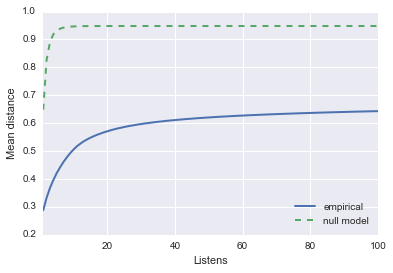

In [447]:
fig,ax = plt.subplots(1,1)
scrobbles = np.nanmean(np.vstack(df[df['basis']=='scrobble']['d'].values),axis=0)
scrobbles_rand = np.nanmean(np.vstack(df_random[df_random['basis']=='scrobble']['d'].values),axis=0)
ax.plot(np.arange(1,101,1),scrobbles,lw=2,label='empirical')
ax.plot(np.arange(1,101,1),scrobbles_rand,lw=2,ls='--',label='null model')
ax.legend(loc='lower right')
ax.set_ylabel('Mean distance')
ax.set_xlabel('Listens')
ax.set_xlim(1,len(scrobbles))

In [ ]:
df_patches = pd.read_table('../testData/patch_blockdists_concat',header=None,names=['user','basis','d']).drop_duplicates(['user','basis'])
df_patches['d'] = df_patches['d'].apply(lambda s: np.array(s.split(','),dtype=float))
print len(df_patches['user'].unique())

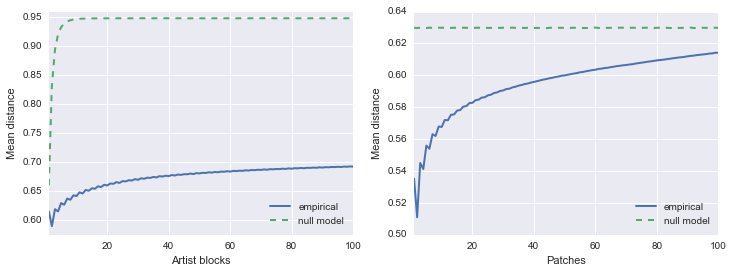

In [449]:
fig,ax = plt.subplots(1,1)#,figsize=(12,8))
blocks = np.nanmean(np.vstack(df[df['basis']=='block']['d'].values),axis=0)
blocks_rand = np.nanmean(np.vstack(df_random[df_random['basis']=='block']['d'].values),axis=0)
ax.plot(np.arange(1,101,1),blocks,lw=2,label='empirical')
ax.plot(np.arange(1,101,1),blocks_rand,lw=2,ls='--',label='null model')
ax.set_ylabel('Mean distance')
ax.set_xlabel('Artist blocks')
ax.set_xlim(1,len(blocks))
ax.legend(loc='lower right')
ax.set_ylim(0.575,.96)



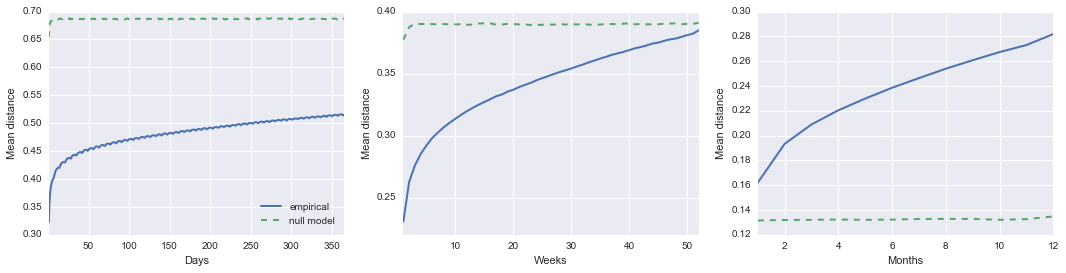

In [439]:
fig,axes = plt.subplots(1,3,figsize=(18,4))
#fig,ax = plt.subplots(1,1,figsize=(12,8))
for i,basis in enumerate(['D','W','M']):
    blocks = np.nanmean(np.vstack(df[df['basis']==basis]['d'].values),axis=0)
    blocks_rand = np.nanmean(np.vstack(df_random[df_random['basis']==basis]['d'].values),axis=0)
    ax = axes[i]
    ax.plot(np.arange(1,len(blocks)+1,1),blocks,lw=2,label='empirical')
    ax.plot(np.arange(1,len(blocks_rand)+1,1),blocks_rand,lw=2,label='null model',ls='--')
    ax.set_ylabel('Mean distance')
    ax.set_xlabel({'D':'Days','W':'Weeks','M':'Months'}[basis])
    ax.set_xlim(1,len(blocks))
    if i ==0:
        ax.legend(loc='lower right')
    #ax.set_ylim(0,1)
    #ax.set_xticks(np.arange(0,98,7))

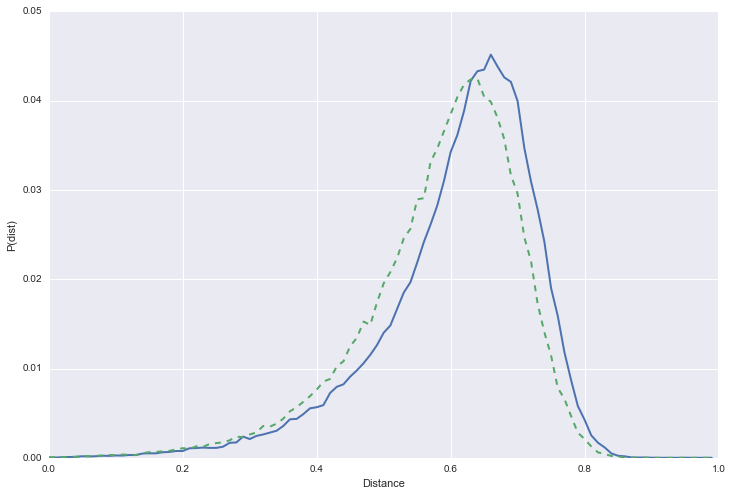

In [275]:
### Comparison of block0-block1 and block0-block2 distance distributions
arr = np.vstack(df[df['basis']=='block']['d'].values)
fig,ax = plt.subplots(1,1,figsize=(12,8))
bins = np.arange(0,1.01,0.01)
vals,toss = np.histogram(arr[:,0],bins=bins)
ax.plot(bins[:-1],vals/float(vals.sum()),label="Block0-Block1 distance",lw=2)
vals,toss = np.histogram(arr[:,1],bins=bins)
ax.plot(bins[:-1],vals/float(vals.sum()),label="Block0-Block2 distance",lw=2,ls='--')
ax.set_xlabel('Distance')
ax.set_ylabel('P(dist)')

84528


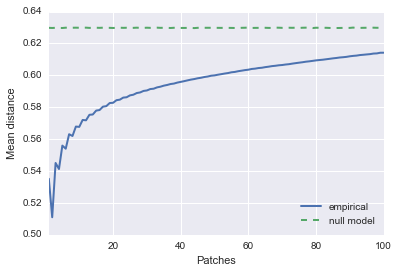

In [450]:
# patch-based analyses 

df = pd.read_table('../testData/patch_blockdists_concat',header=None,names=['user','basis','d']).drop_duplicates(['user','basis'])
df['d'] = df['d'].apply(lambda s: np.array(s.split(','),dtype=float))
print len(df['user'].unique())
fig,ax = plt.subplots(1,1)#,figsize=(12,8))
blocks = np.nanmean(np.vstack(df[df['basis']=='patch']['d'].values),axis=0)
blocks_rand = np.nanmean(np.vstack(df[df['basis']=='patch_random']['d'].values),axis=0)
ax.plot(np.arange(1,101,1),blocks,lw=2,label='empirical')
ax.plot(np.arange(1,101,1),blocks_rand,lw=2,ls='--',label='null model')
ax.set_ylabel('Mean distance')
ax.set_xlabel('Patches')
ax.set_xlim(1,len(blocks))
ax.legend(loc='lower right')

# Patch diversity distributions

91874


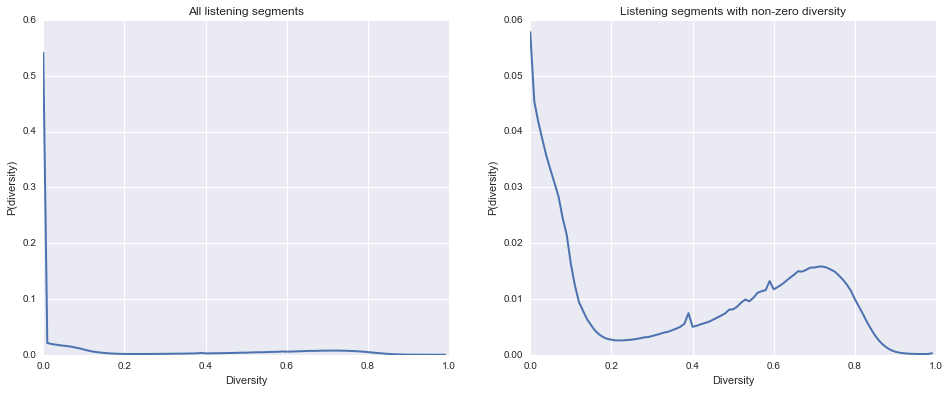

In [459]:
df = pd.read_table('../testData/diversity_concat',header=None,names=['user','basis','d']).drop_duplicates(['user','basis'])
print len(df['user'].unique())
df['d'] = df['d'].apply(lambda s: np.array(s.split(','),dtype=float))
bins = np.arange(0,1.01,.01)

fig,axes = plt.subplots(1,2,figsize=(16,6))
zeros = np.nanmean(np.vstack(df[df['basis']=='zeros']['d'].values),axis=0)
nozeros = np.nanmean(np.vstack(df[df['basis']=='nozeros']['d'].values),axis=0)

axes[0].plot(zeros,lw=2,label='including zeros')
#axes[0].set_yscale('log')
axes[1].plot(nozeros,lw=2,ls='-',label='excluding zeros')
for ax in axes:
    ax.set_ylabel('P(diversity)')
    ax.set_xlabel('Diversity')
    ax.set_xlim(1,len(blocks))
    ax.set_xticks(np.arange(0,101,20))
    ax.set_xticklabels(np.arange(0,1.01,.2))
axes[0].set_title('All listening segments')
axes[1].set_title('Listening segments with non-zero diversity')
#axes[0].legend(loc='upper right')

# Gap analysis (artist level)

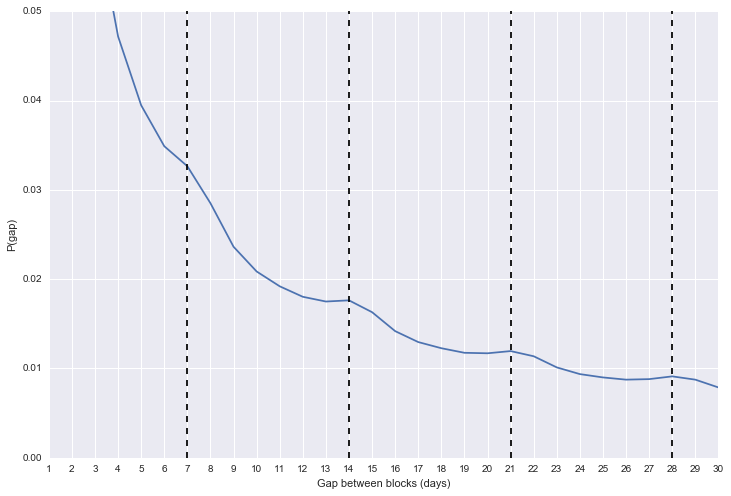

In [182]:
# import pandas as pd
# import numpy as np
# df = pd.read_table('test',header=None,names=['user','d']).drop_duplicates(['user'])
# df['d'] = df['d'].apply(lambda s: np.array(s.split(','),dtype=float))
# result = np.nanmean(np.vstack(df['d']),axis=0)
# result

x=np.array([ 0.3724982 ,  0.09270428,  0.06095183,  0.04718468,  0.03947697,
        0.03489556,  0.03265157,  0.02851   ,  0.02363414,  0.02086439,
        0.01920391,  0.01802927,  0.01749849,  0.01763104,  0.01630397,
        0.01418248,  0.01295734,  0.01226865,  0.01175618,  0.01170099,
        0.0119483 ,  0.01136754,  0.0101201 ,  0.0093693 ,  0.00899711,
        0.00874891,  0.0088069 ,  0.00911558,  0.00874766,  0.00787465])

fig,ax = plt.subplots(1,1,figsize=(12,8))
ax.set_xticks(range(31))
ax.set_xticklabels(range(1,31))
ax.plot(x)
ax.set_ylim(0,0.05)
for y in (6,13,20,27):
    ax.axvline(y,ls='--',c='k')
ax.set_xlabel('Gap between blocks (days)')
ax.set_ylabel('P(gap)');


# Gap analysis (scrobble level)

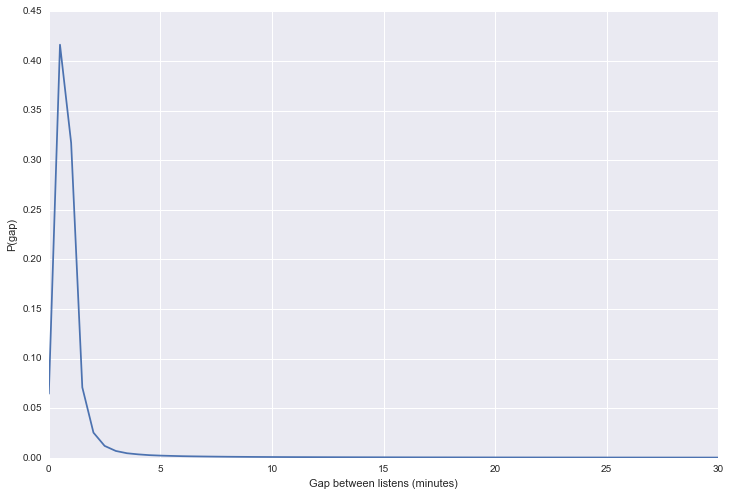

In [245]:
# import numpy as np
# arr = np.loadtxt('scrobble_td_concat_nouser',delimiter=',',dtype=float)
# result = np.nanmean(arr,axis=0)
# np.save('/home/jlorince/scrobble_td.npy',result)

x=np.load('../testData/scrobble_td.npy')
#x = pd.Series(x).cumsum()

fig,ax = plt.subplots(1,1,figsize=(12,8))
ax.plot(x)
ax.set_xlim(0,60)
ax.set_xticks(np.arange(0,61,10))
ax.set_xticklabels(np.arange(0,31,5))
# for y in (6,13,20,27):
#     ax.axvline(y,ls='--',c='k')
ax.set_xlabel('Gap between listens (minutes)')
ax.set_ylabel('P(gap)');



# Explore / Exploit

In [68]:
result_exploit = []
with open('../testData/exploit_concat') as fin:
    for i,line in enumerate(fin):
        try:

            arrs = line.strip().split('\t')[1].split(':')
            data,indices,indptr = [np.array(eval('[{}]'.format(a))) for a in arrs]
            arr = csr_matrix((data,indices,indptr),dtype=float).toarray().flatten()
            #arr[arr==0] = np.nan

            if len(arr)<500:
                arr = np.pad(arr,(0,500-len(arr)),mode='constant',constant_values=np.nan)
            result_exploit.append(arr[:500])
        except:
            continue



In [69]:
result_explore = []
with open('../testData/explore_concat') as fin:
    for i,line in enumerate(fin):
        try:
            arrs = line.strip().split('\t')[1].split(':')
            data,indices,indptr = [np.array(eval('[{}]'.format(a))) for a in arrs]
            arr = csr_matrix((data,indices,indptr),dtype=float).toarray().flatten()
            #arr[arr==0] = np.nan

            if len(arr)<500:
                arr = np.pad(arr,(0,500-len(arr)),mode='constant',constant_values=np.nan)
            result_explore.append(arr[:500])
        except:
            continue
            
result_explore_lastexploit = []
with open('../testData/ee_results_last_exploit_concat') as fin:
    for i,line in enumerate(fin):
        try:
            arrs = line.strip().split('\t')[1].split(':')
            data,indices,indptr = [np.array(eval('[{}]'.format(a))) for a in arrs]
            arr = csr_matrix((data,indices,indptr),dtype=float).toarray().flatten()
            #arr[arr==0] = np.nan

            if len(arr)<500:
                arr = np.pad(arr,(0,500-len(arr)),mode='constant',constant_values=np.nan)
            result_explore_lastexploit.append(arr[:500])
        except:
            continue            


In [25]:
arr_exploit = np.vstack(result_exploit)
arr_explore = np.vstack(result_explore)

483
483


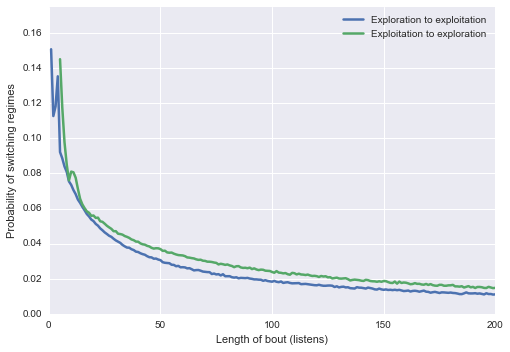

In [76]:
#fig,axes = plt.subplots(1,2,figsize=(12,4))
max_x = 200

fig,ax = plt.subplots(1,1)
for i,result in enumerate((result_exploit,result_explore)):
    #ax= axes[i]
    arr = np.vstack(result)
    #arr[arr==1] = np.nan
    plt_result = np.nanmean(arr,0)
    if i==1:
        #the_min = 4+plt_result[4:].argmin()
        plt_result[:4] = np.nan
    #else:
    #     the_min = plt_result.argmin()
    ax.plot(range(1,500+1),plt_result,lw=2.5,label={0:'Exploration to exploitation',1:'Exploitation to exploration'}[i])#ls={0:'-',1:'--'}[i])
    #ax.axvline(the_min,c='k',ls='--',lw=.5)
    #ax.axvline(3,c='k',ls='--',lw=.5)
    ax.set_xlim(0,200)
    #ax.set_ylim(0.05,.2)
    ax.set_ylabel('Probability of switching regimes')
    ax.set_xlabel('Length of bout (listens)')
    print the_min
    ax.set_ylim(0,0.175)
ax.legend(loc='upper right',fontsize='x-large')


#axes[0].set_title('Exploration to exploitation')
#axes[1].set_title('Exploitation to exploration')

                        
# fig,axes = plt.subplots(1,2,figsize=(12,4))
# for i,result in enumerate((result_exploit,result_explore_lastexploit)):
#     ax= axes[i]
#     arr = np.vstack(result)
#     #arr[arr==1] = np.nan
#     plt_result = np.nanmean(arr,0)
#     if i==1:
#         #the_min = 4+plt_result[4:].argmin()
#         plt_result[:4] = np.nan
#     #else:
#     #     the_min = plt_result.argmin()
#     ax.plot(range(1,500+1),plt_result,lw=1.5)
#     #ax.axvline(the_min,c='k',ls='--',lw=.5)
#     #ax.axvline(3,c='k',ls='--',lw=.5)
#     ax.set_xlim(0,200)
#     #ax.set_ylim(0.05,.2)
#     ax.set_ylabel('Probability of switching regimes')
#     ax.set_xlabel('Length of bout (listens)')
#     print the_min
#     ax.set_ylim(0,0.22)


# axes[0].set_title('Exploration to exploitation')
# axes[1].set_title('Exploitation to exploration')

In [88]:
### SEGMENT LENGTH DISTRIBUTIOn

result_exploit = np.zeros(257363)
result_explore = np.zeros(257363)
with open('../testData/ee_segments_concat') as fin:
    for i,line in enumerate(fin):
        try:

            arrs = line.strip().split('\t')[2].split(':')
            data,indices,indptr = [np.array(eval('[{}]'.format(a))) for a in arrs]
            arr = csr_matrix((data,indices,indptr),dtype=float,shape=(1,257363)).toarray().flatten()
            #if len(arr)<500:
            #    arr = np.pad(arr,(0,500-len(arr)),mode='constant',constant_values=0)
            if 'explore' in line:
                #result_explore.append(arr[:500])
                result_explore += arr
            if 'exploit' in line:
                #result_exploit.append(arr[:500])
                result_exploit += arr
        except:
            continue



In [103]:
np.arange(1,257363+1)*result_explore

array([ 10126409.,  13035254.,  17588772., ...,         0.,         0.,
               0.])

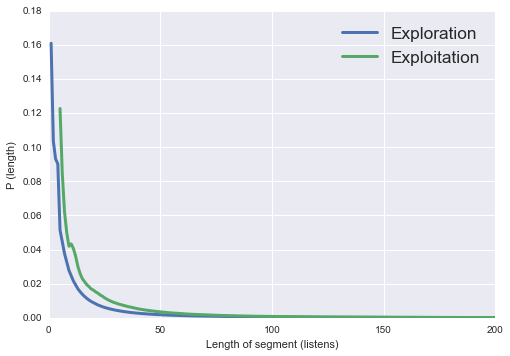

In [97]:
#fig,axes = plt.subplots(1,2,figsize=(12,4))
max_x = 200
fig,ax = plt.subplots(1,1)
#ax = axes[0]
for i,result in enumerate((result_explore,result_exploit)):

    #arr = np.vstack(result).sum(0)
    #arr[arr==1] = np.nan
    #plt_result = arr / float(arr.sum())
    plt_result = result / float(result.sum())
    if i == 1:
        plt_result[:4] = np.nan
    ax.plot(range(1,257363+1),plt_result,lw=3,label={0:'Exploration',1:'Exploitation'}[i])
    ax.set_xlim(0,200)
    #ax.set_ylim(0.05,.2)
    ax.set_ylabel('P (length)')
    ax.set_xlabel('Length of segment (listens)')
    ax.set_ylim(0,0.18)
    #ax.set_yscale("log")
    #ax.set_xscale('log')
    ax.legend(loc = 'upper right',fontsize='x-large')
#axes[0].set_title('Exploration')
#axes[1].set_title('Exploitation')

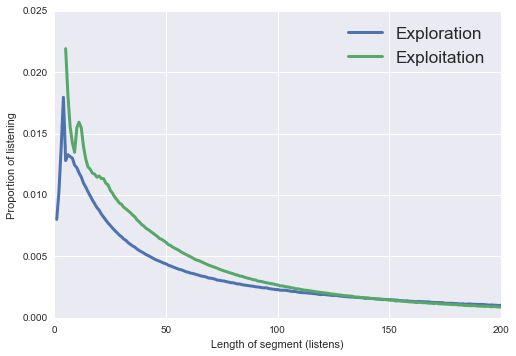

In [105]:

#fig,axes = plt.subplots(1,2,figsize=(12,4))
max_x = 200
fig,ax = plt.subplots(1,1)
#ax = axes[0]
for i,result in enumerate((result_explore,result_exploit)):

    #arr = np.vstack(result).sum(0)
    #arr[arr==1] = np.nan
    #plt_result = arr / float(arr.sum())
    result = (np.arange(1,257363+1)*result)
    plt_result = result / float(result.sum())
    if i == 1:
        plt_result[:4] = np.nan
    ax.plot(range(1,257363+1),plt_result,lw=3,label={0:'Exploration',1:'Exploitation'}[i])
    ax.set_xlim(0,200)
    #ax.set_ylim(0.05,.2)
    ax.set_ylabel('Proportion of listening')
    ax.set_xlabel('Length of segment (listens)')
    #ax.set_ylim(0,0.18)
    #ax.set_yscale("log")
    #ax.set_xscale('log')
    ax.legend(loc = 'upper right',fontsize='x-large')
#axes[0].set_title('Exploration')
#axes[1].set_title('Exploitation')

In [15]:
# SIMPLE SWITCH FROM ARTIST PROBABILITY

result_artists = []
with open('../testData/ee_artists_concat') as fin:
    for i,line in enumerate(fin):
        try:
            arrs = line.strip().split('\t')[1].split(':')
            data,indices,indptr = [np.array(eval('[{}]'.format(a))) for a in arrs]
            arr = csr_matrix((data,indices,indptr),dtype=float).toarray().flatten()
            #arr[arr==0] = np.nan

            if len(arr)<500:
                arr = np.pad(arr,(0,500-len(arr)),mode='constant',constant_values=np.nan)
            result_artists.append(arr[:500])
        except:
            continue


(91882, 500)
96


(0, 0.25)

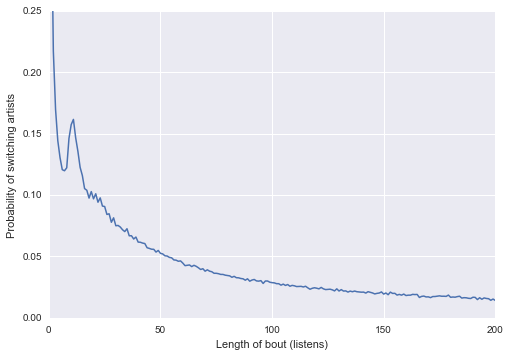

In [18]:
fig,ax = plt.subplots(1,1)
arr = np.vstack(result_artists)
print arr.shape
plt_result = np.nanmean(arr,0)
ax.plot(plt_result,lw=1.5)
#the_min = plt_result[:100].argmin()
#ax.axvline(the_min,c='k',ls='--',lw=.5)
#ax.axvline(10,c='k',ls='--',lw=.5)
ax.set_xlim(0,200)
#ax.set_ylim(0.05,.2)
ax.set_ylabel('Probability of switching artists')
ax.set_xlabel('Length of bout (listens)')
print the_min
ax.set_ylim(0,0.25)

In [79]:
### ARTIST-BASED EXPLORE/EXPLOIT

result_exploit_artists = []
result_explore_artists = []
with open('../testData/ee_artists_2_concat') as fin:
    for i,line in enumerate(fin):
        try:

            arrs = line.strip().split('\t')[2].split(':')
            data,indices,indptr = [np.array(eval('[{}]'.format(a))) for a in arrs]
            arr = csr_matrix((data,indices,indptr),dtype=float).toarray().flatten()
            #arr[arr==0] = np.nan
            if len(arr)<500:
                arr = np.pad(arr,(0,500-len(arr)),mode='constant',constant_values=np.nan)
            if 'explore' in line:
                result_explore_artists.append(arr[:500])
            if 'exploit' in line:
                result_exploit_artists.append(arr[:500])
        except:
            continue



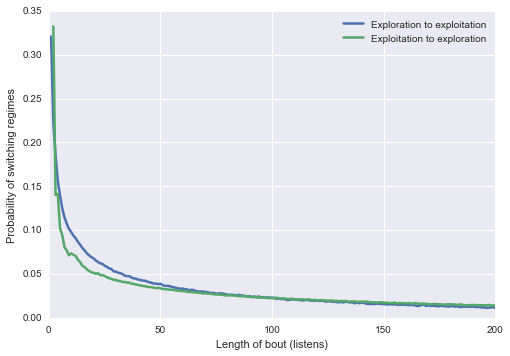

In [85]:
#fig,axes = plt.subplots(1,2,figsize=(12,4))
max_x = 200
fig,ax = plt.subplots(1,1)
for i,result in enumerate((result_explore_artists,result_exploit_artists)):
    #ax= axes[i]
    arr = np.vstack(result)
    #arr[arr==1] = np.nan
    plt_result = np.nanmean(arr,0)
    
#     if i==1:
#         the_min = 2+plt_result[2:].argmin()
#     else:
#         the_min = plt_result.argmin()
    if i==1:
        plt_result[:1] = np.nan
    ax.plot(range(1,500+1),plt_result,lw=2.5,label={0:'Exploration to exploitation',1:'Exploitation to exploration'}[i])    
    ax.axvline(the_min,c='k',ls='--',lw=.5)
    #ax.axvline(3,c='k',ls='--',lw=.5)
    ax.set_xlim(0,200)
    #ax.set_ylim(0.05,.2)
    ax.set_ylabel('Probability of switching regimes')
    ax.set_xlabel('Length of bout (listens)')
    #ax.set_ylim(0,0.25)
ax.legend()

#axes[0].set_title('Exploration to exploitation')
#axes[1].set_title('Exploitation to exploration')

                        



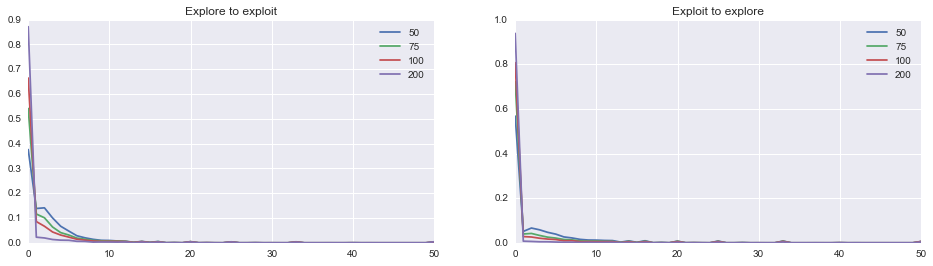

In [7]:
arr_exploit = np.vstack(result_exploit)
arr_explore = np.vstack(result_explore)

fig,axes = plt.subplots(1,2,figsize=(16,4))
bins = np.arange(0,1.01,.01)
#bins = np.arange(0,.2,.001)
#l_vals = (5,10,25,50)
l_vals = (50,75,100,200)
#l_vals = (50,55,60,65,70)

ax = axes[0]
for i in l_vals:
    vals = np.histogram(arr_exploit[:,i][~np.isnan(arr_exploit[:,i])],bins=bins)[0]
    #vals = np.histogram(arr_exploit[:,i][arr_exploit[:,i]<.2],bins=bins)[0]
    vals = vals / float(vals.sum())
    ax.plot(vals,label=i)
ax.legend(loc='upper right')
#ax.set_xticklabels([0,.2,.4,.6,1.])
ax.set_xlim(0,50)
#ax.set_ylim(0,.05)
ax.set_title('Explore to exploit')

ax = axes[1]
for i in l_vals:
    vals = np.histogram(arr_explore[:,i][~np.isnan(arr_explore[:,i])],bins=bins)[0]
    #vals = np.histogram(arr_explore[:,i][arr_explore[:,i]<.2],bins=bins)[0]
    vals = vals / float(vals.sum())
    ax.plot(vals,label=i)
ax.legend(loc='upper right')
#ax.set_xticklabels([0,.2,.4,.6,1.])
ax.set_xlim(0,50)
#ax.set_ylim(0,.05)
ax.set_title('Exploit to explore')


# Explore / Exploit (more scratch)

In [86]:
df_ee = pd.read_table('../testData/ee_concat',header=None,names=['user','basis','d']).dropna()
df_ee = df_ee[df_ee['basis']=='exploit-value-vs-explore']
#unpacked = pd.read_pickle('../testData/ee_concat_unpacked')

In [88]:
df_ee.head()

,user,basis,d
5,10000074,exploit-value-vs-explore,"1:0.0393381567219,2:0.0390290271325,3:0.039841..."
11,1000023,exploit-value-vs-explore,"1:0.00797807972894,2:0.00819224992029,3:0.0068..."
17,10000238,exploit-value-vs-explore,"1:0.046718671316,2:0.0447253653436,3:0.0516475..."
23,10000403,exploit-value-vs-explore,"1:0.399675060926,2:0.270511779041,3:0.20278229..."
29,10000453,exploit-value-vs-explore,"1:0.0266048793785,3:0.0153780252731,4:0.019890..."


In [89]:
def parser(s):
    result = pd.Series(eval('{{{}}}'.format(s.replace('nan','np.nan'))))
    topsum = result[result.index>=500].sum()
    result = result.reindex(xrange(1,501))
    result.ix[500]
    return result

unpacked = df_ee['d'].apply(parser)
# unpacked['user'] = df_ee['user']
# unpacked['basis'] = df_ee['basis']
# unpacked.to_pickle('../testData/ee_concat_unpacked')
# unpacked.to_csv('../testData/ee_concat_unpacked.csv')

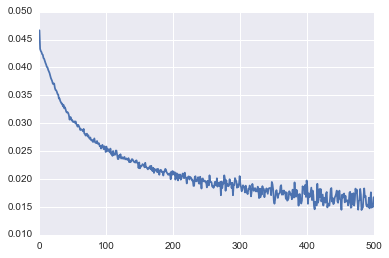

In [96]:
fig,ax = plt.subplots(1,1)
exploit_value_vs_explore = np.nanmean(np.array(unpacked),axis=0)
ax.plot(exploit_value_vs_explore)
#ax.set_xlim(1,100)

#ax.axvline(10,c='k')

In [182]:
unpacked.head()

,1,2,3,4,5,6,7,8,9,10,...,493,494,495,496,497,498,499,500,user,basis
0,9.684211,10.576087,10.795699,9.160494,9.622642,9.592593,9.236842,9.810811,10.184211,9.368421,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000074,next-exploit-vs-explore
1,15.377193,15.543478,15.688172,15.790123,13.943396,12.327273,11.815789,15.000000,12.868421,13.868421,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000074,total-exploit-vs-explore
2,NaN,NaN,NaN,NaN,9.434483,8.500000,7.705128,10.630137,9.773585,9.534884,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000074,explore-vs-exploit
3,114.000000,92.000000,93.000000,81.000000,53.000000,53.000000,38.000000,37.000000,38.000000,38.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000074,prob-explore-given-exploit
4,NaN,NaN,NaN,NaN,145.000000,106.000000,78.000000,74.000000,53.000000,43.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000074,prob-exploit-given-explore


(1, 100)

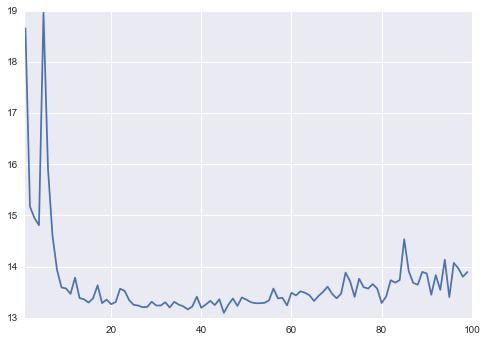

In [82]:
fig,ax = plt.subplots(1,1)
next_exploit_vs_explore = np.nanmean(np.array(unpacked[unpacked['basis']=='next-exploit-vs-explore'][range(1,100)]),axis=0)
ax.plot(range(1,100),next_exploit_vs_explore)
ax.set_xlim(1,100)
#ax.axvline(4)


(1, 100)

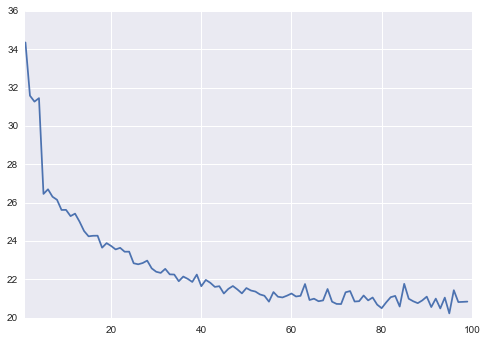

In [99]:
fig,ax = plt.subplots(1,1)
total_exploit_vs_explore = np.nanmean(np.array(unpacked[unpacked['basis']=='total-exploit-vs-explore'][range(1,100)]),axis=0)
ax.plot(range(1,100),total_exploit_vs_explore)
ax.set_xlim(1,100)


(5, 100)

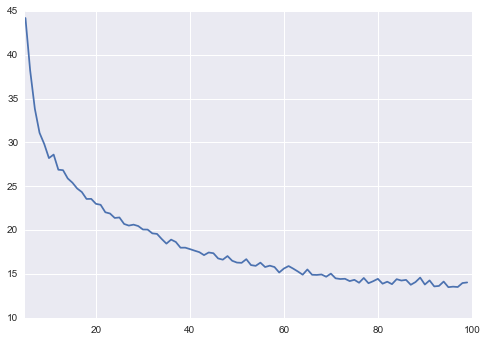

In [86]:
fig,ax = plt.subplots(1,1)
explore_vs_exploit = np.nanmean(np.array(unpacked[unpacked['basis']=='explore-vs-exploit'][range(1,100)]),axis=0)
ax.plot(range(1,100),explore_vs_exploit)
ax.set_xlim(5,100)
#ax.axvline(4)


(1, 100)

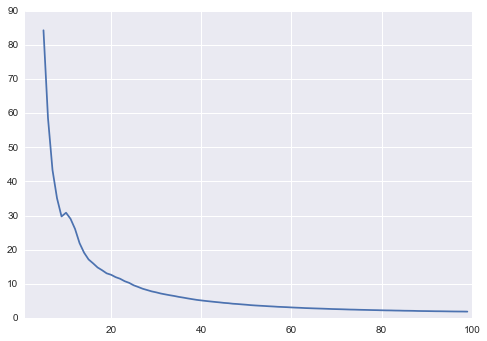

In [94]:
# NAMES SWITCHED!!
fig,ax = plt.subplots(1,1)
prob_exploit_given_explore = np.nanmean(np.array(unpacked[unpacked['basis']=='prob-exploit-given-explore'][range(1,100)]),axis=0)
ax.plot(range(1,100),prob_exploit_given_explore)
ax.set_xlim(1,100)

#ax.axvline(10,c='k')

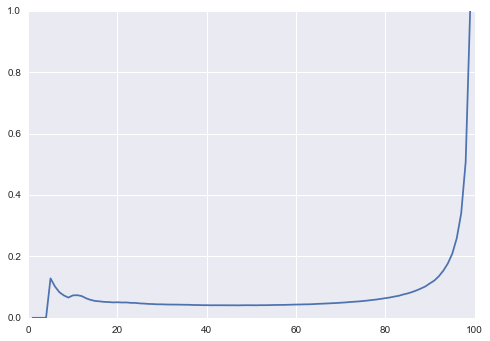

In [121]:
arr = np.array(unpacked[unpacked['basis']=='prob-exploit-given-explore'][range(1,100)].fillna(0))
plt.plot(range(1,100),arr.sum(0)/np.cumsum(arr.sum(0)[::-1])[::-1])
#plt.gca().axvline(5,c='k')

(1, 100)

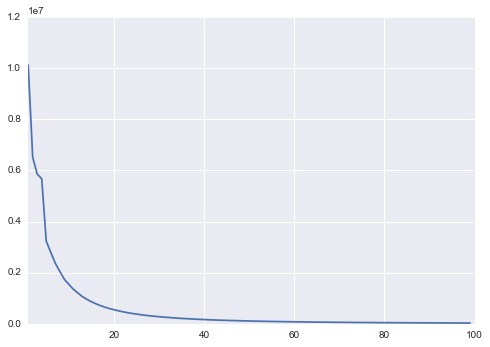

In [103]:
# NAMES SWITCHED!!
fig,ax = plt.subplots(1,1)
prob_explore_given_exploit = np.nansum(np.array(unpacked[unpacked['basis']=='prob-explore-given-exploit'][range(1,100)]),axis=0)
ax.plot(range(1,100),prob_explore_given_exploit)
ax.set_xlim(1,100)

#ax.axvline(4,c='k')

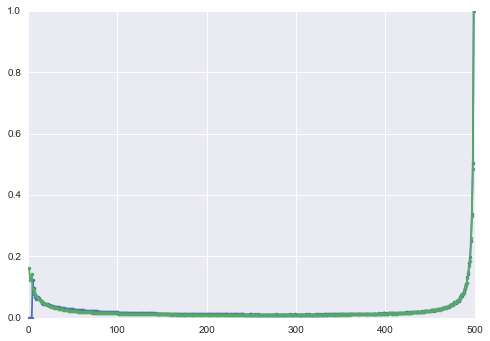

In [225]:
arr = np.array(unpacked[unpacked['basis']=='prob-exploit-given-explore'][range(1,500)].fillna(0))
plt.plot(range(1,500),arr.sum(0)/np.cumsum(arr.sum(0)[::-1])[::-1],marker='.')
#plt.gca().axvline(5,c='k')

arr2 = np.array(unpacked[unpacked['basis']=='prob-explore-given-exploit'][range(1,500)].fillna(0))
plt.plot(range(1,500),arr2.sum(0)/(np.cumsum(arr2.sum(0)[::-1])[::-1]),marker='.')
#arr.sum(0)/np.cumsum(arr.sum(0)[::-1])[::-1]


#plt.gca().set_ylim(0,.2)
#plt.gca().set_xlim(1,200)

In [223]:
(pd.Series(arr.sum(0)).cumsum()/arr.sum())[:1000]

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.122944
5      0.207873
6      0.270216
7      0.320229
8      0.362228
9      0.405645
10     0.446263
11     0.482404
12     0.512490
13     0.538397
14     0.561359
15     0.582565
16     0.601994
17     0.620224
18     0.637120
19     0.653319
20     0.668466
21     0.682913
22     0.696267
23     0.708918
24     0.720569
25     0.731509
26     0.741714
27     0.751339
28     0.760386
29     0.769031
         ...   
469    0.999748
470    0.999757
471    0.999767
472    0.999777
473    0.999786
474    0.999795
475    0.999804
476    0.999814
477    0.999823
478    0.999832
479    0.999841
480    0.999850
481    0.999858
482    0.999866
483    0.999875
484    0.999884
485    0.999893
486    0.999901
487    0.999909
488    0.999918
489    0.999927
490    0.999935
491    0.999944
492    0.999952
493    0.999960
494    0.999968
495    0.999976
496    0.999984
497    0.999992
498    1.000000
dtype: float64

(1, 100)

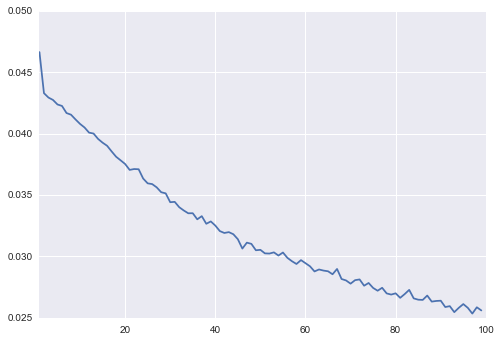

# Explore / Exploit (old)

In [368]:
df_ee = pd.read_table('../testData/temp',header=None,names=['user','basis','d'])
df_ee['d'] = df_ee['d'].apply(lambda s: np.array(s.split(','),dtype=float)).apply(lambda x: np.pad(x,(0,1001-len(x)),mode='constant'))


In [427]:
print len(df_ee['user'].unique())

12753


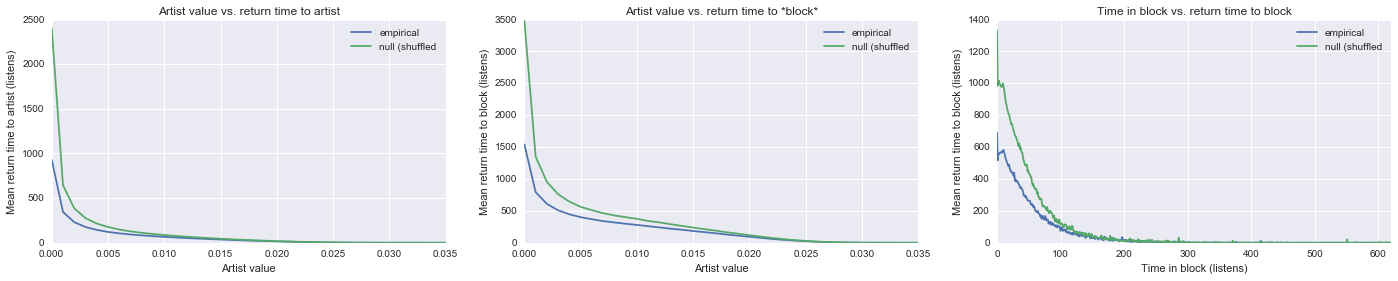

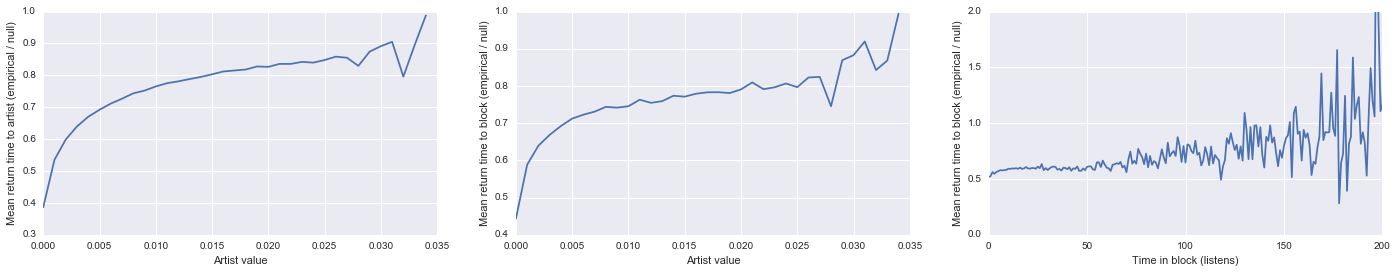

In [428]:
fig,axes = plt.subplots(1,3,figsize=(24,4))
fig2,axes2 = plt.subplots(1,3,figsize=(24,4))

flat = axes.flat
flat2 = axes2.flat

ax = flat.next()
ax.set_title('Artist value vs. return time to artist')
arr_emp = np.vstack(df_ee[df_ee['basis']=='scrobbles_rt_value']['d']).mean(0)
arr_rand = np.vstack(df_ee[df_ee['basis']=='scrobbles_rt_value_rand']['d']).mean(0)
ax.plot(np.arange(len(arr_emp))/1000.,arr_emp,label='empirical')
ax.plot(np.arange(len(arr_rand))/1000.,arr_rand,label='null (shuffled')
ax.set_xlabel('Artist value')
ax.set_ylabel('Mean return time to artist (listens)')
ax.set_xlim(0,max(arr_emp.argmin()/1000.,arr_rand.argmin()/1000.))
ax.legend(loc='upper right')

ax2 = flat2.next()
ax2.plot(np.arange(len(arr_emp))/1000.,arr_emp/arr_rand)
ax2.set_xlabel('Artist value')
ax2.set_ylabel('Mean return time to artist (empirical / null)')
ax2.set_xlim(0,max(arr_emp.argmin()/1000.,arr_rand.argmin()/1000.))
ax2.legend(loc='upper right')

####----####
ax = flat.next()
ax.set_title('Artist value vs. return time to *block*')
arr_emp = np.vstack(df_ee[df_ee['basis']=='blocks_rt']['d']).mean(0)
arr_rand = np.vstack(df_ee[df_ee['basis']=='blocks_rt_value_rand']['d']).mean(0)
ax.plot(np.arange(len(arr_emp))/1000.,arr_emp,label='empirical')
ax.plot(np.arange(len(arr_rand))/1000.,arr_rand,label='null (shuffled')
ax.set_xlim(0,max(arr_emp.argmin()/1000.,arr_rand.argmin()/1000.))
ax.set_xlabel('Artist value')
ax.set_ylabel('Mean return time to block (listens)')
ax.legend(loc='upper right')

ax2 = flat2.next()
ax2.plot(np.arange(len(arr_emp))/1000.,arr_emp/arr_rand)
ax2.set_xlabel('Artist value')
ax2.set_ylabel('Mean return time to block (empirical / null)')
ax2.set_xlim(0,max(arr_emp.argmin()/1000.,arr_rand.argmin()/1000.))
ax2.legend(loc='upper right')

####----####
ax = flat.next()
ax.set_title('Time in block vs. return time to block')
arr_emp = np.vstack(df_ee[df_ee['basis']=='blocks_rt_n']['d']).mean(0)
arr_rand = np.vstack(df_ee[df_ee['basis']=='blocks_rt_n_rand']['d']).mean(0)
ax.plot(arr_emp,label='empirical')
ax.plot(arr_rand,label='null (shuffled')
ax.set_xlim(0,max(arr_emp.argmin(),arr_rand.argmin()))
ax.set_xlabel('Time in block (listens)')
ax.set_ylabel('Mean return time to block (listens)')
ax.legend(loc='upper right')

ax2 = flat2.next()
ax2.plot(np.arange(len(arr_emp)),arr_emp/arr_rand)
ax2.set_xlabel('Time in block (listens)')
ax2.set_ylabel('Mean return time to block (empirical / null)')
ax2.set_ylim(0,2)
ax2.set_xlim(0,200)
ax2.legend(loc='upper right')

